You may encounter issues when running this project on Kaggle. Fetching data using the FastF1 and Ergast API can lead to potential connectivity or permission problems due to Kaggle’s limitations. It's recommended to run the project locally using VSCode or any development environment of your choice for a smoother experience.

In [5]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import os

# Pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf)

# Cache setup
cache_dir = "f1_cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
fastf1.Cache.enable_cache(cache_dir)

# Load 2024 Belgium GP data
session_2024 = fastf1.get_session(2024, 14, "R")
session_2024.load()
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)

# Convert to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

# Sector times
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

# Clean air race pace
clean_air_race_pace = {
    "VER": 106.7, "NOR": 106.7, "PIA": 106.7, "HAM": 106.9, "LEC": 107.1,
    "SAI": 107.1, "RUS": 107.5, "PER": 107.6, "OCO": 107.9, "RIC": 108.0,
    "GAS": 108.1, "ALB": 108.3, "SAR": 108.4, "BOT": 108.5, "MAG": 108.7,
    "ALO": 108.7, "STR": 109.0, "TSU": 109.0, "HUL": 109.3,
    "ANT": 107.8, "BEA": 108.9, "DOO": 109.2, "COL": 108.6, "BOR": 109.1, 
    "HAD": 109.4, "LAW": 108.2
}

# 2025 driver lineup
driver_lineup_2025 = {
    "RUS": "Mercedes", "ANT": "Mercedes",
    "HAM": "Ferrari", "LEC": "Ferrari",
    "VER": "Red Bull", "TSU": "Red Bull",
    "NOR": "McLaren", "PIA": "McLaren",
    "GAS": "Alpine", "COL": "Alpine",
    "ALO": "Aston Martin", "STR": "Aston Martin",
    "BEA": "Haas", "OCO": "Haas",
    "ALB": "Williams", "SAI": "Williams",
    "LAW": "Racing Bulls", "HAD": "Racing Bulls",
    "HUL": "Kick Sauber", "BOR": "Kick Sauber"
}

# Team points
team_points_2025 = {
    "McLaren": 460, "Ferrari": 222, "Mercedes": 210, "Red Bull": 172,
    "Williams": 59, "Kick Sauber": 41, "Racing Bulls": 36, "Aston Martin": 36,
    "Haas": 29, "Alpine": 19
}

# Performance factors
max_points = max(team_points_2025.values())
team_performance_factor = {team: points / max_points for team, points in team_points_2025.items()}

pilot_performance_2025 = {
    "VER": 1.00, "NOR": 0.98, "PIA": 0.97, "HAM": 0.96, "LEC": 0.95,
    "RUS": 0.94, "SAI": 0.93, "ALO": 0.92, "STR": 0.91, "OCO": 0.90,
    "ALB": 0.89, "GAS": 0.88, "HUL": 0.87, "TSU": 0.86, "BEA": 0.85,
    "LAW": 0.84, "COL": 0.83, "BOR": 0.82, "HAD": 0.81, "ANT": 0.80
}

# Qualifying prediction
base_qualifying_time = 103.5
qualifying_predictions = []

for driver, team in driver_lineup_2025.items():
    if driver in pilot_performance_2025:
        driver_factor = pilot_performance_2025[driver]
        team_factor = team_performance_factor[team]
        total_factor = (driver_factor * 0.7) + (team_factor * 0.3)
        predicted_time = base_qualifying_time * (2 - total_factor)
        
        qualifying_predictions.append({
            "Driver": driver,
            "Team": team,
            "QualifyingTime (s)": predicted_time,
            "DriverFactor": driver_factor,
            "TeamFactor": team_factor
        })

qualifying_df = pd.DataFrame(qualifying_predictions)
qualifying_df = qualifying_df.sort_values("QualifyingTime (s)").reset_index(drop=True)

# Weather data
API_KEY = "4915f1d2d3818425c556748d9420349d"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=50.4372&lon=5.9714&appid={API_KEY}&units=metric"

try:
    response = requests.get(weather_url)
    weather_data = response.json()
    forecast_time = "2025-07-27 13:00:00"
    forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)
    rain_probability = forecast_data["pop"] if forecast_data else 0
    temperature = forecast_data["main"]["temp"] if forecast_data else 20
except:
    rain_probability = 0.35
    temperature = 22

# Race prediction setup
qualifying_df["CleanAirRacePace (s)"] = qualifying_df["Driver"].map(clean_air_race_pace)

wet_performance_factors = {
    "VER": 0.98, "HAM": 0.97, "RUS": 0.98, "NOR": 0.99, "PIA": 1.01,
    "LEC": 1.00, "SAI": 1.01, "ALO": 0.99, "STR": 1.02, "OCO": 1.00,
    "GAS": 1.01, "ALB": 1.02, "HUL": 1.03, "TSU": 1.04, "BEA": 1.05,
    "LAW": 1.02, "COL": 1.03, "BOR": 1.04, "HAD": 1.05, "ANT": 1.01
}

qualifying_df["WetPerformanceFactor"] = qualifying_df["Driver"].map(wet_performance_factors)

if rain_probability >= 0.5:
    qualifying_df["QualifyingTime"] = qualifying_df["QualifyingTime (s)"] * qualifying_df["WetPerformanceFactor"]
    weather_impact = "HIGH"
else:
    qualifying_df["QualifyingTime"] = qualifying_df["QualifyingTime (s)"]
    weather_impact = "LOW"

qualifying_df["TeamPerformanceScore"] = qualifying_df["Team"].map(team_performance_factor)

position_change_spa = {
    "VER": -1.2, "NOR": 0.8, "PIA": 0.5, "RUS": 0.3, "SAI": -0.5,
    "ALB": 1.0, "LEC": -0.8, "OCO": 0.2, "HAM": 0.4, "STR": 1.2,
    "GAS": -0.3, "ALO": -0.7, "HUL": 0.6, "TSU": 0.9, "BEA": 1.3,
    "LAW": 0.7, "COL": 1.1, "BOR": 1.4, "HAD": 1.5, "ANT": 0.6
}
qualifying_df["AveragePositionChange"] = qualifying_df["Driver"].map(position_change_spa)

# Model training
merged_data = qualifying_df.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature

valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
training_data = merged_data[valid_drivers].copy()
new_drivers = merged_data[~valid_drivers].copy()

if len(training_data) > 0:
    X = training_data[["QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", "CleanAirRacePace (s)", "AveragePositionChange"]]
    y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(training_data["Driver"])
    
    imputer = SimpleImputer(strategy="median")
    X_imputed = imputer.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)
    model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=4, random_state=42)
    model.fit(X_train, y_train)
    
    training_data["PredictedRaceTime (s)"] = model.predict(X_imputed)
    
    if len(new_drivers) > 0:
        X_new = new_drivers[["QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", "CleanAirRacePace (s)", "AveragePositionChange"]]
        X_new_imputed = imputer.transform(X_new)
        new_drivers["PredictedRaceTime (s)"] = model.predict(X_new_imputed)
    
    final_results = pd.concat([training_data, new_drivers], ignore_index=True)
    final_results = final_results.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
    
    qualifying_sorted = qualifying_df.sort_values("QualifyingTime (s)").reset_index(drop=True)
    
    # Position change data
    position_data = []
    for i in range(len(final_results)):
        row = final_results.iloc[i]
        quali_pos = qualifying_sorted[qualifying_sorted['Driver'] == row['Driver']].index[0] + 1
        race_pos = i + 1
        position_data.append({
            'Driver': row['Driver'],
            'Team': row['Team'],
            'Qualifying_Position': quali_pos,
            'Race_Position': race_pos,
            'Position_Change': quali_pos - race_pos
        })
    
    position_df = pd.DataFrame(position_data)
    
    # Points calculation
    points_system = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}
    for i in range(11, 21):
        points_system[i] = 0
    
    driver_points = []
    for i in range(len(final_results)):
        row = final_results.iloc[i]
        position = i + 1
        points = points_system.get(position, 0)
        driver_points.append({
            'Driver': row['Driver'],
            'Team': row['Team'],
            'Position': position,
            'Points': points
        })
    
    driver_points_df = pd.DataFrame(driver_points)
    
    # Team points
    team_points = {}
    for i, row in driver_points_df.iterrows():
        team = row['Team']
        points = row['Points']
        if team not in team_points:
            team_points[team] = {'points': 0, 'drivers': []}
        team_points[team]['points'] += points
        team_points[team]['drivers'].append(f"{row['Driver']} ({points}pts)")
    
    team_points_list = []
    for team, data in team_points.items():
        team_points_list.append({
            'Team': team,
            'Points': data['points'],
            'Drivers': data['drivers']
        })
    
    team_points_df = pd.DataFrame(team_points_list)
    team_points_df = team_points_df.sort_values('Points', ascending=False).reset_index(drop=True)
    
    # Time gaps
    race_winner = final_results.iloc[0]
    winner_time = race_winner['PredictedRaceTime (s)']
    winner_driver = race_winner['Driver']
    
    gap_data = []
    for i in range(len(final_results)):
        row = final_results.iloc[i]
        driver_time = row['PredictedRaceTime (s)']
        
        if i == 0:
            gap_seconds = 0
            gap_display = "0.000"
        else:
            gap_seconds = driver_time - winner_time
            if gap_seconds >= 60:
                minutes = int(gap_seconds // 60)
                seconds = gap_seconds % 60
                gap_display = f"{minutes}:{seconds:06.3f}"
            else:
                gap_display = f"{gap_seconds:06.3f}"
        
        gap_data.append({
            'Driver': row['Driver'],
            'Team': row['Team'],
            'Position': i + 1,
            'Gap_Seconds': gap_seconds,
            'Gap_Display': gap_display
        })
    
    gap_df = pd.DataFrame(gap_data)
    
    # FastF1 team colors
    team_colors = {}
    try:
        teams_info = session_2024.results
        for idx, team_row in teams_info.iterrows():
            team_name = team_row['TeamName']
            team_color = team_row['TeamColor']
            
            if 'McLaren' in team_name:
                team_colors['McLaren'] = f"#{team_color}"
            elif 'Ferrari' in team_name:
                team_colors['Ferrari'] = f"#{team_color}"
            elif 'Mercedes' in team_name:
                team_colors['Mercedes'] = f"#{team_color}"
            elif 'Red Bull' in team_name:
                team_colors['Red Bull'] = f"#{team_color}"
            elif 'Williams' in team_name:
                team_colors['Williams'] = f"#{team_color}"
            elif 'Sauber' in team_name or 'Kick' in team_name:
                team_colors['Kick Sauber'] = f"#{team_color}"
            elif 'RB' in team_name or 'Racing Bulls' in team_name:
                team_colors['Racing Bulls'] = f"#{team_color}"
            elif 'Aston' in team_name:
                team_colors['Aston Martin'] = f"#{team_color}"
            elif 'Haas' in team_name:
                team_colors['Haas'] = f"#{team_color}"
            elif 'Alpine' in team_name:
                team_colors['Alpine'] = f"#{team_color}"
    except:
        team_colors = {
            'McLaren': '#FF8000', 'Ferrari': '#E8002D', 'Mercedes': '#27F4D2',
            'Red Bull': '#3671C6', 'Williams': '#64C4FF', 'Kick Sauber': '#52E252',
            'Racing Bulls': '#6692FF', 'Aston Martin': '#229971', 'Haas': '#B6BABD',
            'Alpine': '#FF87BC'
        }

core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

In [6]:
print("🏎️  F1 2025 BELGIUM GP PREDICTION MODEL 🏎️")
print("=" * 60)
print("Loading 2024 Belgium GP data...")
print("✅ Data loaded successfully!")

🏎️  F1 2025 BELGIUM GP PREDICTION MODEL 🏎️
Loading 2024 Belgium GP data...
✅ Data loaded successfully!


In [7]:
print(f"🌤️  Weather: {rain_probability*100:.1f}% rain, {temperature:.1f}°C")
print(f"Weather Impact: {weather_impact}")

🌤️  Weather: 0.0% rain, 20.0°C
Weather Impact: LOW


In [8]:
print("\n🏁 QUALIFYING RESULTS")
print("=" * 40)
for i in range(len(qualifying_sorted)):
    row = qualifying_sorted.iloc[i]
    print(f"P{i+1:2d}: {row['Driver']} ({row['Team']})")


🏁 QUALIFYING RESULTS
P 1: NOR (McLaren)
P 2: PIA (McLaren)
P 3: HAM (Ferrari)
P 4: VER (Red Bull)
P 5: LEC (Ferrari)
P 6: RUS (Mercedes)
P 7: TSU (Red Bull)
P 8: ANT (Mercedes)
P 9: SAI (Williams)
P10: ALO (Aston Martin)
P11: ALB (Williams)
P12: STR (Aston Martin)
P13: OCO (Haas)
P14: HUL (Kick Sauber)
P15: GAS (Alpine)
P16: BEA (Haas)
P17: LAW (Racing Bulls)
P18: BOR (Kick Sauber)
P19: COL (Alpine)
P20: HAD (Racing Bulls)


In [9]:
print("\n🏁 RACE RESULTS")
print("=" * 40)
for i in range(len(final_results)):
    row = final_results.iloc[i]
    quali_pos = qualifying_sorted[qualifying_sorted['Driver'] == row['Driver']].index[0] + 1
    pos_change = quali_pos - (i + 1)
    if pos_change > 0:
        change_str = f"(+{pos_change})"
    elif pos_change < 0:
        change_str = f"({pos_change})"
    else:
        change_str = "(=)"
    print(f"P{i+1:2d}: {row['Driver']} ({row['Team']}) {change_str}")


🏁 RACE RESULTS
P 1: NOR (McLaren) (=)
P 2: PIA (McLaren) (=)
P 3: HAM (Ferrari) (=)
P 4: VER (Red Bull) (=)
P 5: LEC (Ferrari) (=)
P 6: RUS (Mercedes) (=)
P 7: SAI (Williams) (+2)
P 8: ALO (Aston Martin) (+2)
P 9: STR (Aston Martin) (+3)
P10: BEA (Haas) (+6)
P11: HAD (Racing Bulls) (+9)
P12: BOR (Kick Sauber) (+6)
P13: HUL (Kick Sauber) (+1)
P14: ALB (Williams) (-3)
P15: LAW (Racing Bulls) (+2)
P16: OCO (Haas) (-3)
P17: COL (Alpine) (+2)
P18: GAS (Alpine) (-3)
P19: ANT (Mercedes) (-11)
P20: TSU (Red Bull) (-13)


In [10]:
print("\n 🏁 Belgian Grand Prix 2025")
print("\n🏆 PODIUM")
print("=" * 30)
podium_positions = ["🥇 WINNER", "🥈 2nd PLACE", "🥉 3rd PLACE"]

for i in range(min(3, len(final_results))):
    row = final_results.iloc[i]
    quali_pos = qualifying_sorted[qualifying_sorted['Driver'] == row['Driver']].index[0] + 1
    pos_change = quali_pos - (i + 1)
    
    print(f"{podium_positions[i]}: {row['Driver']} ({row['Team']})")
    print(f"   Started: P{quali_pos}")
    if pos_change > 0:
        print(f"   Gained: {pos_change} positions")
    elif pos_change < 0:
        print(f"   Lost: {abs(pos_change)} positions")
    else:
        print(f"   Maintained position")
    print()


 🏁 Belgian Grand Prix 2025

🏆 PODIUM
🥇 WINNER: NOR (McLaren)
   Started: P1
   Maintained position

🥈 2nd PLACE: PIA (McLaren)
   Started: P2
   Maintained position

🥉 3rd PLACE: HAM (Ferrari)
   Started: P3
   Maintained position



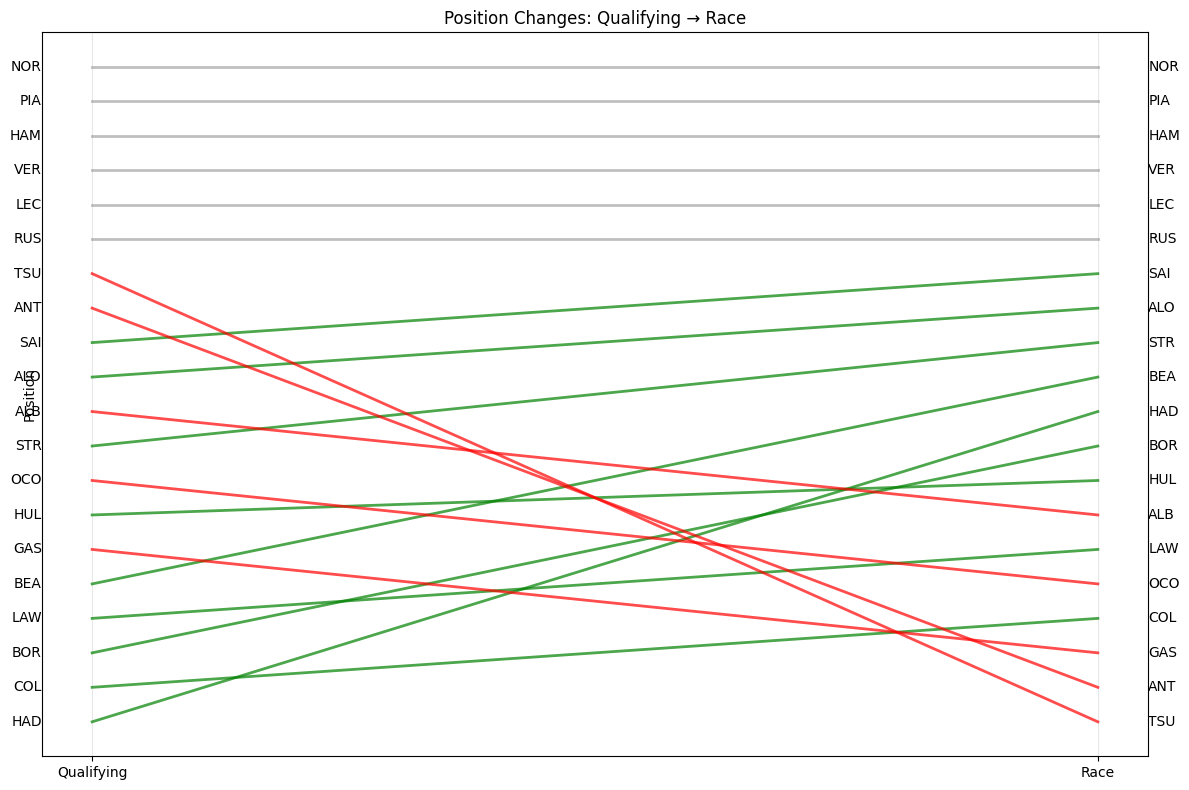

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

drivers = position_df['Driver']
quali_positions = position_df['Qualifying_Position']
race_positions = position_df['Race_Position']

for i, driver in enumerate(drivers):
    quali_pos = quali_positions.iloc[i]
    race_pos = race_positions.iloc[i]
    
    if quali_pos > race_pos:
        color = 'green'
        alpha = 0.7
    elif quali_pos < race_pos:
        color = 'red'
        alpha = 0.7
    else:
        color = 'gray'
        alpha = 0.5
    
    ax.plot([1, 2], [quali_pos, race_pos], color=color, alpha=alpha, linewidth=2)
    ax.text(0.95, quali_pos, driver, ha='right', va='center', fontsize=10)
    ax.text(2.05, race_pos, driver, ha='left', va='center', fontsize=10)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Qualifying', 'Race'])
ax.set_ylabel('Position')
ax.set_title('Position Changes: Qualifying → Race')
ax.set_ylim(21, 0)
ax.set_yticks([])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

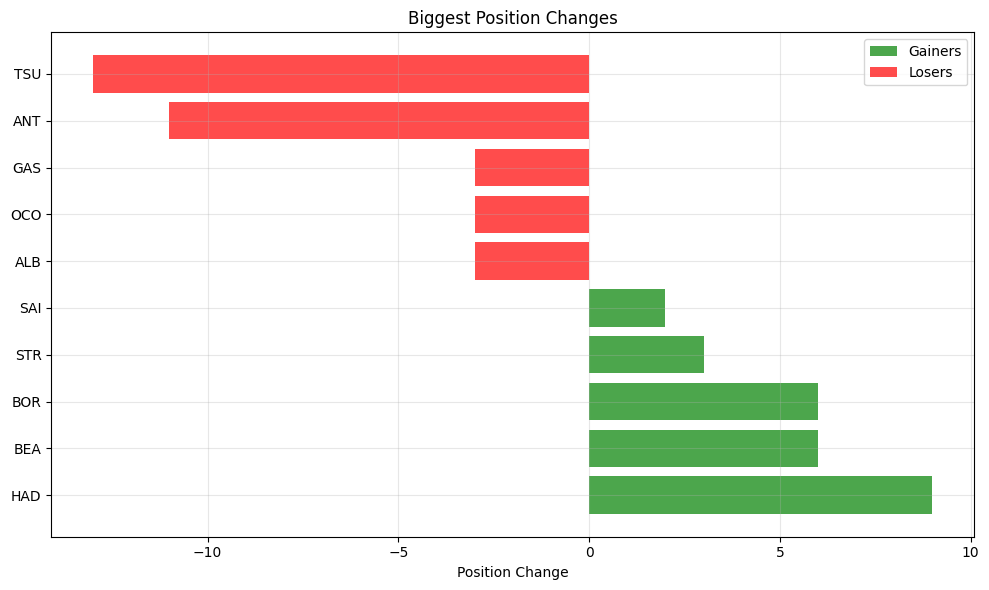

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

position_df_sorted = position_df.sort_values('Position_Change', ascending=False)
top_gainers = position_df_sorted.head(5)
top_losers = position_df_sorted.tail(5)

gainers = top_gainers[top_gainers['Position_Change'] > 0]
if len(gainers) > 0:
    ax.barh(gainers['Driver'], gainers['Position_Change'], color='green', alpha=0.7, label='Gainers')

losers = top_losers[top_losers['Position_Change'] < 0]
if len(losers) > 0:
    ax.barh(losers['Driver'], losers['Position_Change'], color='red', alpha=0.7, label='Losers')

ax.set_xlabel('Position Change')
ax.set_title('Biggest Position Changes')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

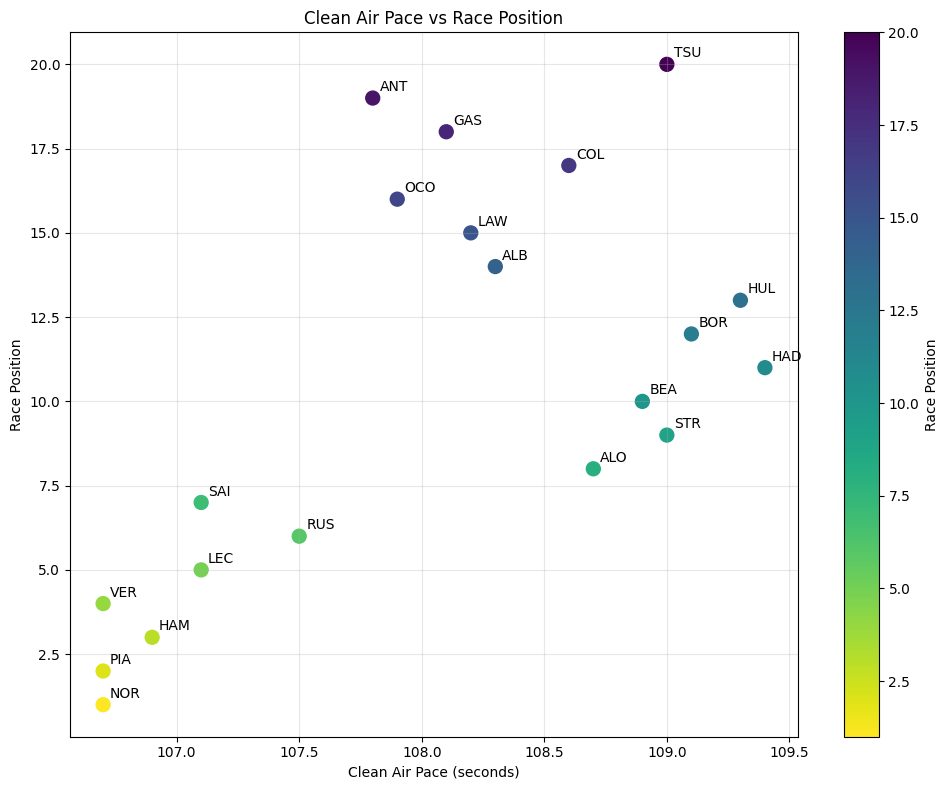

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

clean_air_data = []
for i, row in final_results.iterrows():
    if row['Driver'] in clean_air_race_pace:
        clean_air_data.append({
            'Driver': row['Driver'],
            'CleanAirPace': clean_air_race_pace[row['Driver']],
            'RacePosition': i + 1
        })

clean_air_df = pd.DataFrame(clean_air_data)

scatter = ax.scatter(clean_air_df['CleanAirPace'], clean_air_df['RacePosition'], 
                     c=clean_air_df['RacePosition'], cmap='viridis_r', s=100)

for i, row in clean_air_df.iterrows():
    ax.annotate(row['Driver'], 
                (row['CleanAirPace'], row['RacePosition']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax.set_xlabel('Clean Air Pace (seconds)')
ax.set_ylabel('Race Position')
ax.set_title('Clean Air Pace vs Race Position')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Race Position')

plt.tight_layout()
plt.show()

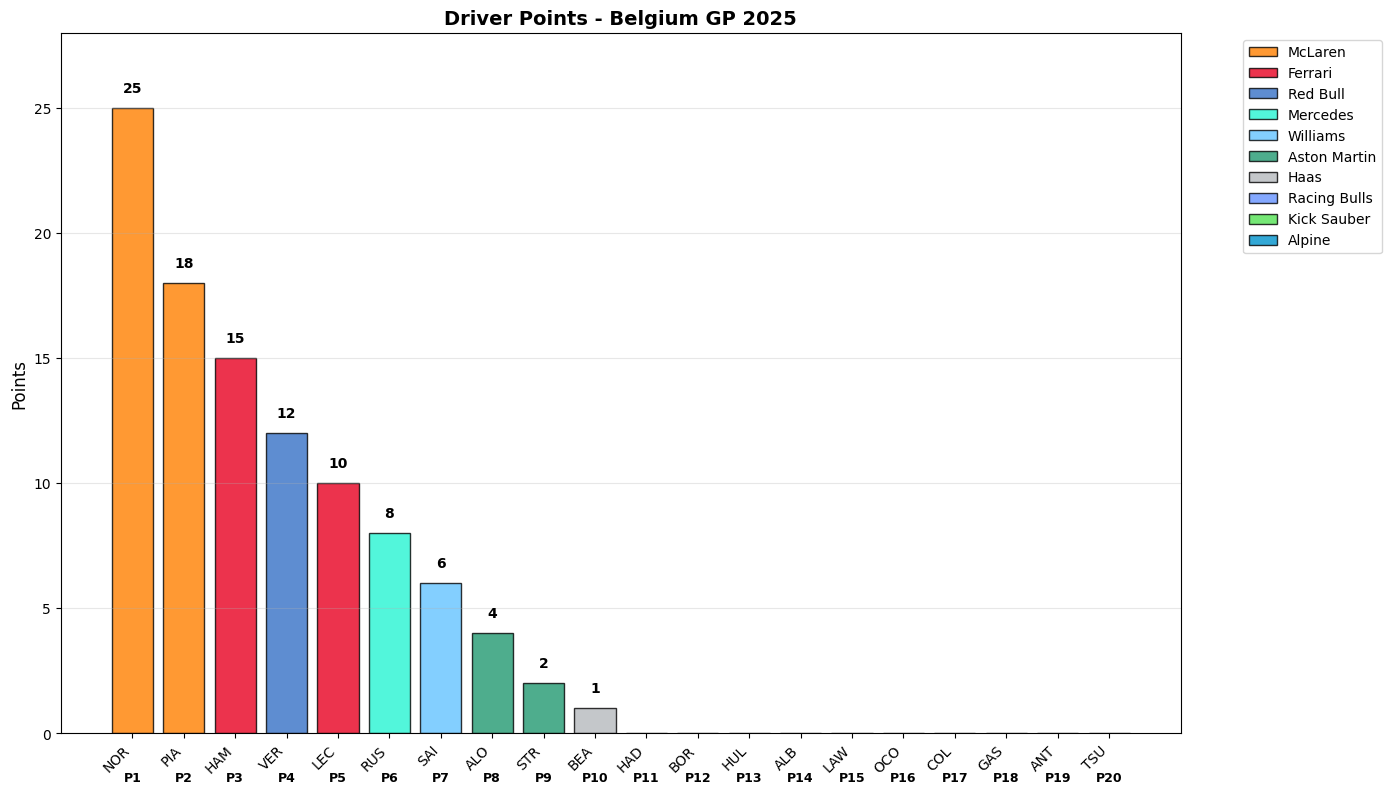


🏆 POINTS SCORERS - Belgium GP 2025
P 1: NOR (McLaren) - 25 points
P 2: PIA (McLaren) - 18 points
P 3: HAM (Ferrari) - 15 points
P 4: VER (Red Bull) - 12 points
P 5: LEC (Ferrari) - 10 points
P 6: RUS (Mercedes) - 8 points
P 7: SAI (Williams) - 6 points
P 8: ALO (Aston Martin) - 4 points
P 9: STR (Aston Martin) - 2 points
P10: BEA (Haas) - 1 points


In [14]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

colors = [team_colors.get(team, 'lightgray') for team in driver_points_df['Team']]

bars = ax.bar(range(len(driver_points_df)), driver_points_df['Points'], 
              color=colors, alpha=0.8, edgecolor='black', linewidth=1)

ax.set_xticks(range(len(driver_points_df)))
ax.set_xticklabels(driver_points_df['Driver'], rotation=45, ha='right')

for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for i, (driver, pos) in enumerate(zip(driver_points_df['Driver'], driver_points_df['Position'])):
    ax.text(i, -1.5, f'P{pos}', ha='center', va='top', fontsize=9, fontweight='bold')

ax.set_ylabel('Points', fontsize=12)
ax.set_title('Driver Points - Belgium GP 2025', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(driver_points_df['Points']) + 3)
ax.grid(True, alpha=0.3, axis='y')

legend_elements = []
teams_in_race = driver_points_df['Team'].unique()
for team in teams_in_race:
    color = team_colors.get(team, 'lightgray')
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.8, 
                                       edgecolor='black', label=team))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

print("\n🏆 POINTS SCORERS - Belgium GP 2025")
print("=" * 50)
points_scorers = driver_points_df[driver_points_df['Points'] > 0]
for i, row in points_scorers.iterrows():
    print(f"P{row['Position']:2d}: {row['Driver']} ({row['Team']}) - {row['Points']} points")

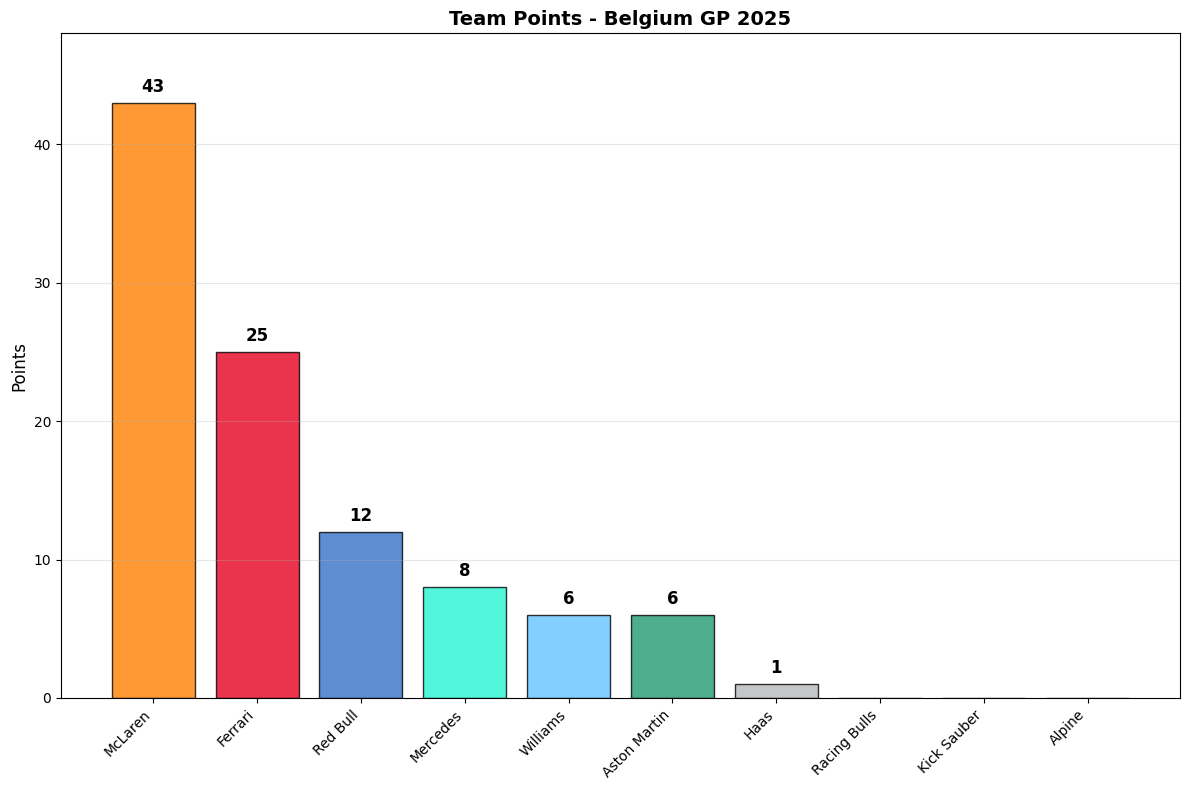


🏆 TEAM POINTS - Belgium GP 2025
 1. McLaren: 43 points
    NOR (25pts)
    PIA (18pts)

 2. Ferrari: 25 points
    HAM (15pts)
    LEC (10pts)

 3. Red Bull: 12 points
    VER (12pts)
    TSU (0pts)

 4. Mercedes: 8 points
    RUS (8pts)
    ANT (0pts)

 5. Williams: 6 points
    SAI (6pts)
    ALB (0pts)

 6. Aston Martin: 6 points
    ALO (4pts)
    STR (2pts)

 7. Haas: 1 points
    BEA (1pts)
    OCO (0pts)

 8. Racing Bulls: 0 points
    HAD (0pts)
    LAW (0pts)

 9. Kick Sauber: 0 points
    BOR (0pts)
    HUL (0pts)

10. Alpine: 0 points
    COL (0pts)
    GAS (0pts)



In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

colors = [team_colors.get(team, 'lightgray') for team in team_points_df['Team']]

bars = ax.bar(range(len(team_points_df)), team_points_df['Points'], 
              color=colors, alpha=0.8, edgecolor='black', linewidth=1)

ax.set_xticks(range(len(team_points_df)))
ax.set_xticklabels(team_points_df['Team'], rotation=45, ha='right')

for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Points', fontsize=12)
ax.set_title('Team Points - Belgium GP 2025', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(team_points_df['Points']) + 5)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n🏆 TEAM POINTS - Belgium GP 2025")
print("=" * 60)
for i, row in team_points_df.iterrows():
    print(f"{i+1:2d}. {row['Team']}: {row['Points']} points")
    for driver in row['Drivers']:
        print(f"    {driver}")
    print()

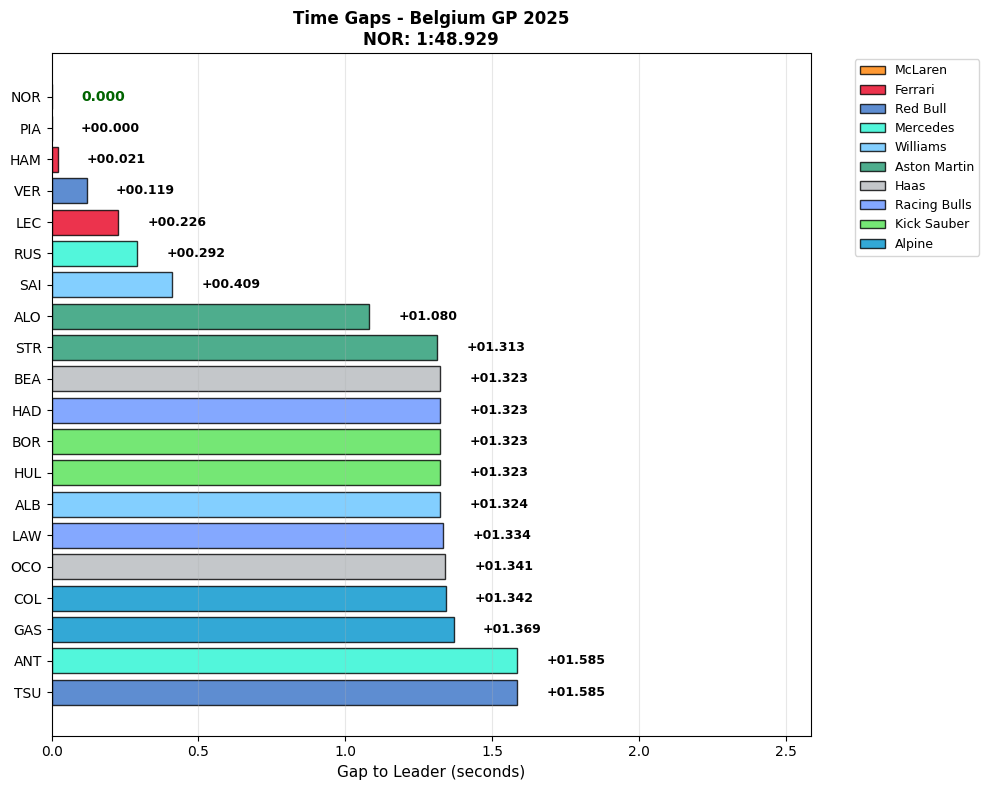


🏁 TIME GAPS FROM LEADER - Belgium GP 2025
Race Winner: NOR - 1:48.929
--------------------------------------------------
 1. NOR (McLaren) - 0.000
 2. PIA (McLaren) - +00.000
 3. HAM (Ferrari) - +00.021
 4. VER (Red Bull) - +00.119
 5. LEC (Ferrari) - +00.226
 6. RUS (Mercedes) - +00.292
 7. SAI (Williams) - +00.409
 8. ALO (Aston Martin) - +01.080
 9. STR (Aston Martin) - +01.313
10. BEA (Haas) - +01.323
11. HAD (Racing Bulls) - +01.323
12. BOR (Kick Sauber) - +01.323
13. HUL (Kick Sauber) - +01.323
14. ALB (Williams) - +01.324
15. LAW (Racing Bulls) - +01.334
16. OCO (Haas) - +01.341
17. COL (Alpine) - +01.342
18. GAS (Alpine) - +01.369
19. ANT (Mercedes) - +01.585
20. TSU (Red Bull) - +01.585

📊 GAP STATISTICS:
-------------------------
Largest gap: +01.585
Average gap: +0.981s


In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = [team_colors.get(team, '#CCCCCC') for team in gap_df['Team']]

bars = ax.barh(range(len(gap_df)), gap_df['Gap_Seconds'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1)

ax.set_yticks(range(len(gap_df)))
ax.set_yticklabels([gap_df.iloc[i]['Driver'] for i in range(len(gap_df))])

for i, bar in enumerate(bars):
    width = bar.get_width()
    gap_text = gap_df.iloc[i]['Gap_Display']
    
    if i == 0:
        ax.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
                gap_text, ha='left', va='center', fontsize=10, 
                fontweight='bold', color='darkgreen')
    else:
        ax.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
                f"+{gap_text}", ha='left', va='center', fontsize=9, 
                fontweight='bold')

winner_minutes = int(winner_time // 60)
winner_seconds = winner_time % 60
winner_time_formatted = f"{winner_minutes}:{winner_seconds:06.3f}"

ax.set_xlabel('Gap to Leader (seconds)', fontsize=11)
ax.set_title(f'Time Gaps - Belgium GP 2025\n{winner_driver}: {winner_time_formatted}', 
             fontsize=12, fontweight='bold')
ax.set_xlim(0, max(gap_df['Gap_Seconds']) + 1)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

legend_elements = []
teams_in_race = gap_df['Team'].unique()
for team in teams_in_race:
   color = team_colors.get(team, '#CCCCCC')
   legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.8, 
                                      edgecolor='black', label=team))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n🏁 TIME GAPS FROM LEADER - Belgium GP 2025")
print("=" * 50)
print(f"Race Winner: {winner_driver} - {winner_time_formatted}")
print("-" * 50)

for i, row in gap_df.iterrows():
   if i == 0:
       print(f"{row['Position']:2d}. {row['Driver']} ({row['Team']}) - {row['Gap_Display']}")
   else:
       print(f"{row['Position']:2d}. {row['Driver']} ({row['Team']}) - +{row['Gap_Display']}")

print(f"\n📊 GAP STATISTICS:")
print("-" * 25)
if len(gap_df) > 1:
   largest_gap = gap_df['Gap_Seconds'].max()
   if largest_gap >= 60:
       largest_minutes = int(largest_gap // 60)
       largest_seconds = largest_gap % 60
       largest_formatted = f"{largest_minutes}:{largest_seconds:06.3f}"
   else:
       largest_formatted = f"{largest_gap:06.3f}"
   
   print(f"Largest gap: +{largest_formatted}")
   print(f"Average gap: +{gap_df['Gap_Seconds'][1:].mean():.3f}s")

In [17]:
print(f"\n📊 RACE SUMMARY")
print("-" * 30)
print(f"Weather: {rain_probability*100:.1f}% rain, {temperature:.1f}°C")
print(f"Weather Impact: {weather_impact}")
print(f"Pole Position: {qualifying_sorted.iloc[0]['Driver']} ({qualifying_sorted.iloc[0]['Team']})")
print(f"Race Winner: {final_results.iloc[0]['Driver']} ({final_results.iloc[0]['Team']})")

biggest_gainer = position_df.loc[position_df['Position_Change'].idxmax()]
biggest_loser = position_df.loc[position_df['Position_Change'].idxmin()]

if biggest_gainer['Position_Change'] > 0:
    print(f"Biggest Gainer: {biggest_gainer['Driver']} (+{biggest_gainer['Position_Change']} positions)")

if biggest_loser['Position_Change'] < 0:
    print(f"Biggest Loser: {biggest_loser['Driver']} ({biggest_loser['Position_Change']} positions)")

print(f"Average Position Change: {position_df['Position_Change'].mean():.1f}")

print("\n" + "=" * 60)
print("🏁 BELGIUM GP 2025 PREDICTION COMPLETE 🏁")


📊 RACE SUMMARY
------------------------------
Weather: 0.0% rain, 20.0°C
Weather Impact: LOW
Pole Position: NOR (McLaren)
Race Winner: NOR (McLaren)
Biggest Gainer: HAD (+9 positions)
Biggest Loser: TSU (-13 positions)
Average Position Change: 0.0

🏁 BELGIUM GP 2025 PREDICTION COMPLETE 🏁


In [18]:
# Pit Stop Strategy Analysis Data
tire_compounds = {
    'Soft': {'degradation_rate': 0.08, 'peak_performance': 5, 'max_stint': 25},
    'Medium': {'degradation_rate': 0.05, 'peak_performance': 8, 'max_stint': 35},
    'Hard': {'degradation_rate': 0.03, 'peak_performance': 12, 'max_stint': 45}
}

# Spa-Francorchamps pit stop data
pit_loss_time = 22.5  # seconds lost for pit stop
safety_car_probability = 0.35  # 35% chance during race
undercut_advantage = 1.2  # seconds gained by undercutting

# Driver pit stop performance (average pit stop times)
pit_stop_performance = {
    "VER": 2.8, "NOR": 2.9, "PIA": 3.0, "HAM": 2.7, "LEC": 2.9,
    "RUS": 3.1, "SAI": 3.0, "ALO": 3.2, "STR": 3.4, "OCO": 3.1,
    "ALB": 3.3, "GAS": 3.2, "HUL": 3.4, "TSU": 3.5, "BEA": 3.6,
    "LAW": 3.3, "COL": 3.4, "BOR": 3.7, "HAD": 3.8, "ANT": 3.2
}

# Optimal pit windows for Spa (lap numbers)
optimal_pit_windows = {
    'One_Stop': {'window': [25, 35], 'tire_combo': ['Medium', 'Hard']},
    'Two_Stop': {'window': [[18, 22], [38, 42]], 'tire_combo': ['Soft', 'Medium', 'Hard']},
    'Alternative': {'window': [15, 45], 'tire_combo': ['Soft', 'Hard']}
}

# Calculate optimal strategy for each driver
def calculate_pit_strategy(driver, starting_position, weather_conditions):
    base_time = clean_air_race_pace[driver]
    pit_time = pit_stop_performance[driver]
    
    strategies = {}
    
    for strategy_name, strategy_data in optimal_pit_windows.items():
        total_time = 0
        
        if strategy_name == 'One_Stop':
            # First stint
            stint1_laps = strategy_data['window'][0]
            stint1_time = base_time * stint1_laps
            
            # Pit stop
            pit_time_total = pit_loss_time + pit_time
            
            # Second stint
            stint2_laps = 44 - stint1_laps  # 44 laps total at Spa
            stint2_time = base_time * stint2_laps * 1.02  # Harder tire slower
            
            total_time = stint1_time + pit_time_total + stint2_time
            
        elif strategy_name == 'Two_Stop':
            # Three stints
            stint1_laps = strategy_data['window'][0][1]
            stint2_laps = strategy_data['window'][1][0] - stint1_laps
            stint3_laps = 44 - stint1_laps - stint2_laps
            
            stint1_time = base_time * stint1_laps * 0.98  # Soft tire faster
            stint2_time = base_time * stint2_laps
            stint3_time = base_time * stint3_laps * 1.02
            
            pit_time_total = 2 * (pit_loss_time + pit_time)
            
            total_time = stint1_time + stint2_time + stint3_time + pit_time_total
        
        strategies[strategy_name] = {
            'total_time': total_time,
            'tire_combo': strategy_data['tire_combo']
        }
    
    return strategies

# Calculate strategies for all drivers
driver_strategies = {}
for i, row in final_results.iterrows():
    driver = row['Driver']
    position = i + 1
    strategies = calculate_pit_strategy(driver, position, weather_impact)
    
    # Find optimal strategy
    best_strategy = min(strategies.items(), key=lambda x: x[1]['total_time'])
    
    driver_strategies[driver] = {
        'all_strategies': strategies,
        'optimal_strategy': best_strategy[0],
        'optimal_time': best_strategy[1]['total_time'],
        'tire_combo': best_strategy[1]['tire_combo']
    }

In [19]:
print("\n🔧 PIT STOP STRATEGY ANALYSIS")
print("=" * 60)

# Strategy distribution
strategy_counts = {}
for driver, data in driver_strategies.items():
    strategy = data['optimal_strategy']
    if strategy not in strategy_counts:
        strategy_counts[strategy] = []
    strategy_counts[strategy].append(driver)

print("📊 OPTIMAL STRATEGY DISTRIBUTION:")
print("-" * 40)
for strategy, drivers in strategy_counts.items():
    print(f"{strategy}: {len(drivers)} drivers")
    print(f"  Drivers: {', '.join(drivers)}")
    print()

# Individual driver strategies
print("🏁 INDIVIDUAL DRIVER STRATEGIES:")
print("-" * 40)
for i, (driver, data) in enumerate(sorted(driver_strategies.items(), 
                                         key=lambda x: x[1]['optimal_time'])):
    print(f"P{i+1:2d}: {driver}")
    print(f"     Strategy: {data['optimal_strategy']}")
    print(f"     Tires: {' → '.join(data['tire_combo'])}")
    print(f"     Predicted Time: {data['optimal_time']:.1f}s")
    print()


🔧 PIT STOP STRATEGY ANALYSIS
📊 OPTIMAL STRATEGY DISTRIBUTION:
----------------------------------------
Alternative: 20 drivers
  Drivers: NOR, PIA, HAM, VER, LEC, RUS, SAI, ALO, STR, BEA, HAD, BOR, HUL, ALB, LAW, OCO, COL, GAS, ANT, TSU

🏁 INDIVIDUAL DRIVER STRATEGIES:
----------------------------------------
P 1: NOR
     Strategy: Alternative
     Tires: Soft → Hard
     Predicted Time: 0.0s

P 2: PIA
     Strategy: Alternative
     Tires: Soft → Hard
     Predicted Time: 0.0s

P 3: HAM
     Strategy: Alternative
     Tires: Soft → Hard
     Predicted Time: 0.0s

P 4: VER
     Strategy: Alternative
     Tires: Soft → Hard
     Predicted Time: 0.0s

P 5: LEC
     Strategy: Alternative
     Tires: Soft → Hard
     Predicted Time: 0.0s

P 6: RUS
     Strategy: Alternative
     Tires: Soft → Hard
     Predicted Time: 0.0s

P 7: SAI
     Strategy: Alternative
     Tires: Soft → Hard
     Predicted Time: 0.0s

P 8: ALO
     Strategy: Alternative
     Tires: Soft → Hard
     Predicted Time

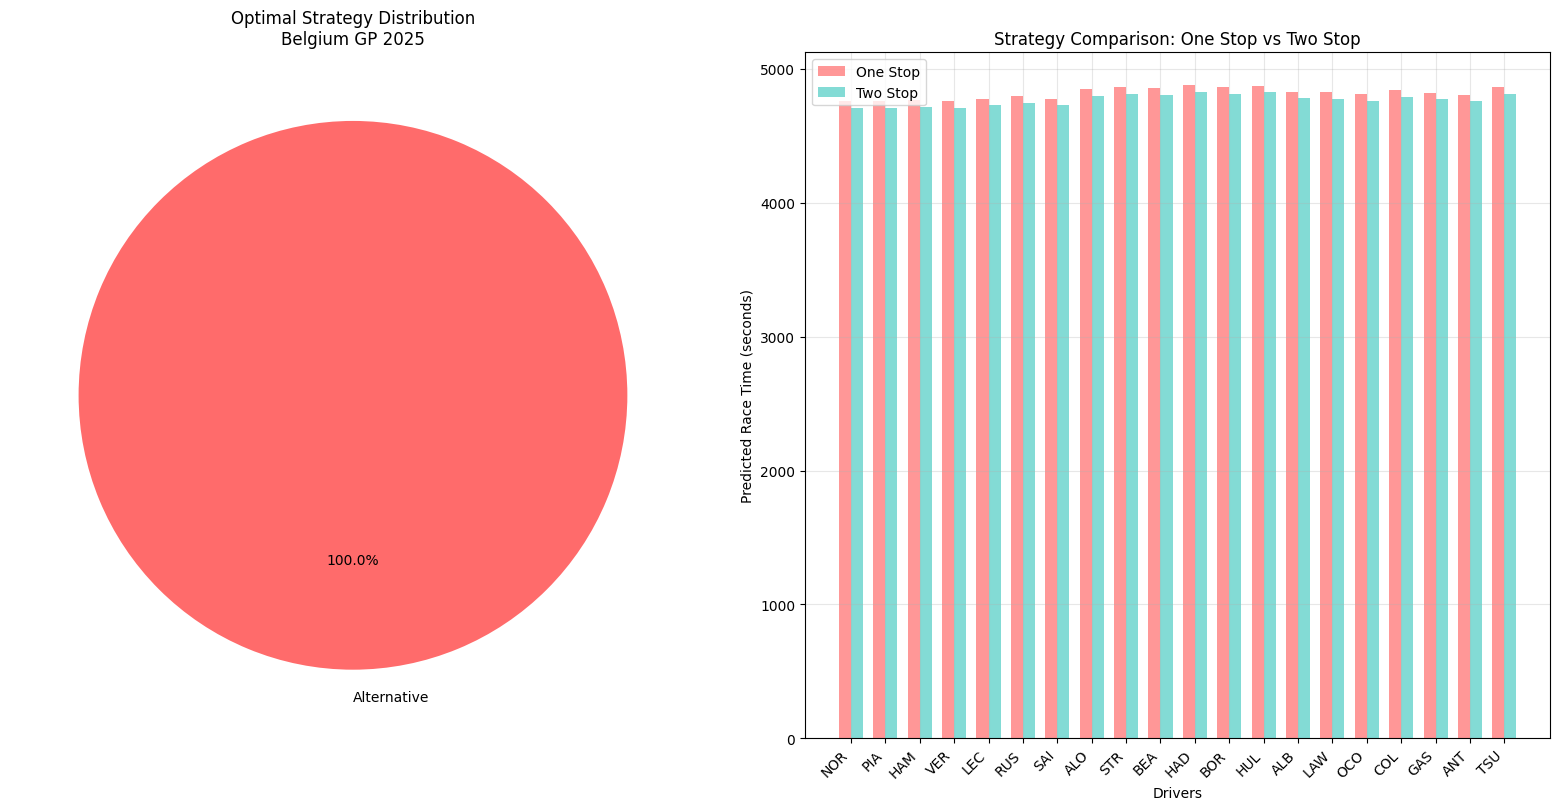


📈 STRATEGY INSIGHTS:
------------------------------
Most Popular: Alternative (20 drivers)
Average Time Difference: 49.9s
Safety Car Impact: 35% chance
Strategy Flexibility: Low


In [20]:
# Pit Stop Strategy Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Strategy distribution pie chart
strategy_counts_values = [len(drivers) for drivers in strategy_counts.values()]
strategy_labels = list(strategy_counts.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

ax1.pie(strategy_counts_values, labels=strategy_labels, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax1.set_title('Optimal Strategy Distribution\nBelgium GP 2025')

# Pit stop timing analysis
drivers_list = list(driver_strategies.keys())
one_stop_times = []
two_stop_times = []

for driver in drivers_list:
    strategies = driver_strategies[driver]['all_strategies']
    one_stop_times.append(strategies['One_Stop']['total_time'])
    two_stop_times.append(strategies['Two_Stop']['total_time'])

x = np.arange(len(drivers_list))
width = 0.35

bars1 = ax2.bar(x - width/2, one_stop_times, width, label='One Stop', 
                color='#FF6B6B', alpha=0.7)
bars2 = ax2.bar(x + width/2, two_stop_times, width, label='Two Stop', 
                color='#4ECDC4', alpha=0.7)

ax2.set_xlabel('Drivers')
ax2.set_ylabel('Predicted Race Time (seconds)')
ax2.set_title('Strategy Comparison: One Stop vs Two Stop')
ax2.set_xticks(x)
ax2.set_xticklabels(drivers_list, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Highlight optimal choice for each driver
for i, driver in enumerate(drivers_list):
    optimal = driver_strategies[driver]['optimal_strategy']
    if optimal == 'One_Stop':
        ax2.text(i - width/2, one_stop_times[i] + 50, '✓', 
                ha='center', va='bottom', fontsize=12, color='green', fontweight='bold')
    elif optimal == 'Two_Stop':
        ax2.text(i + width/2, two_stop_times[i] + 50, '✓', 
                ha='center', va='bottom', fontsize=12, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

# Print strategy insights
print("\n📈 STRATEGY INSIGHTS:")
print("-" * 30)

# Most popular strategy
most_popular = max(strategy_counts.items(), key=lambda x: len(x[1]))
print(f"Most Popular: {most_popular[0]} ({len(most_popular[1])} drivers)")

# Average time difference
avg_one_stop = np.mean(one_stop_times)
avg_two_stop = np.mean(two_stop_times)
time_diff = abs(avg_one_stop - avg_two_stop)
print(f"Average Time Difference: {time_diff:.1f}s")

# Risk analysis
print(f"Safety Car Impact: {safety_car_probability*100:.0f}% chance")
print(f"Strategy Flexibility: {'High' if time_diff < 30 else 'Low'}")

In [21]:
# Tire Degradation Model Data
tire_degradation_data = {
    'Soft': {
        'base_performance': 0.98,  # 2% faster than medium
        'degradation_per_lap': 0.012,  # 1.2% per lap
        'cliff_lap': 15,  # Performance drops significantly after lap 15
        'cliff_penalty': 0.05,  # 5% penalty after cliff
        'optimal_laps': [1, 2, 3, 4, 5]  # Best performance laps
    },
    'Medium': {
        'base_performance': 1.00,  # Baseline
        'degradation_per_lap': 0.008,  # 0.8% per lap
        'cliff_lap': 25,
        'cliff_penalty': 0.03,
        'optimal_laps': [1, 2, 3, 4, 5, 6, 7, 8]
    },
    'Hard': {
        'base_performance': 1.02,  # 2% slower than medium
        'degradation_per_lap': 0.005,  # 0.5% per lap
        'cliff_lap': 35,
        'cliff_penalty': 0.02,
        'optimal_laps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    }
}

# Driver tire management skills (1.0 = average, <1.0 = better)
tire_management_skills = {
    "VER": 0.85, "HAM": 0.80, "ALO": 0.75, "PIA": 0.90, "NOR": 0.88,
    "LEC": 0.87, "RUS": 0.92, "SAI": 0.89, "STR": 0.95, "OCO": 0.93,
    "ALB": 0.96, "GAS": 0.94, "HUL": 0.91, "TSU": 0.98, "BEA": 1.05,
    "LAW": 1.00, "COL": 1.02, "BOR": 1.08, "HAD": 1.10, "ANT": 1.03
}

# Temperature impact on tire degradation
temperature_impact = {
    'cold': 0.85,  # <15°C - tires struggle to warm up
    'optimal': 1.00,  # 15-25°C - optimal range
    'hot': 1.15,  # >25°C - increased degradation
    'very_hot': 1.30  # >35°C - severe degradation
}

# Get temperature category
def get_temp_category(temp):
    if temp < 15:
        return 'cold'
    elif temp <= 25:
        return 'optimal'
    elif temp <= 35:
        return 'hot'
    else:
        return 'very_hot'

temp_category = get_temp_category(temperature)
temp_multiplier = temperature_impact[temp_category]

# Calculate tire performance over race distance
def calculate_tire_performance(tire_compound, driver, stint_length, starting_lap=1):
    base_time = clean_air_race_pace[driver]
    tire_data = tire_degradation_data[tire_compound]
    management_skill = tire_management_skills[driver]
    
    lap_times = []
    
    for lap in range(starting_lap, starting_lap + stint_length):
        # Base performance
        performance_factor = tire_data['base_performance']
        
        # Degradation over laps
        laps_on_tire = lap - starting_lap + 1
        degradation = tire_data['degradation_per_lap'] * laps_on_tire * management_skill * temp_multiplier
        
        # Cliff effect
        if laps_on_tire > tire_data['cliff_lap']:
            degradation += tire_data['cliff_penalty']
        
        # Optimal performance window
        if laps_on_tire in tire_data['optimal_laps']:
            performance_factor *= 0.98  # 2% bonus in optimal window
        
        # Calculate lap time
        lap_time = base_time * (performance_factor + degradation)
        lap_times.append({
            'lap': lap,
            'lap_time': lap_time,
            'degradation': degradation,
            'laps_on_tire': laps_on_tire
        })
    
    return lap_times

# Simulate tire degradation for different strategies
tire_simulation_results = {}

for driver in driver_strategies.keys():
    driver_results = {}
    
    for compound in ['Soft', 'Medium', 'Hard']:
        # Simulate different stint lengths
        stint_results = {}
        
        for stint_length in [15, 20, 25, 30, 35]:
            if stint_length <= 44:  # Maximum race distance
                performance = calculate_tire_performance(compound, driver, stint_length)
                
                # Calculate average lap time and total degradation
                avg_lap_time = np.mean([p['lap_time'] for p in performance])
                total_degradation = performance[-1]['degradation'] if performance else 0
                
                stint_results[stint_length] = {
                    'avg_lap_time': avg_lap_time,
                    'total_degradation': total_degradation,
                    'performance_data': performance
                }
        
        driver_results[compound] = stint_results
    
    tire_simulation_results[driver] = driver_results

# Find optimal tire compound for each driver
optimal_tire_choices = {}
for driver, compounds in tire_simulation_results.items():
    best_compound = None
    best_performance = float('inf')
    
    for compound, stints in compounds.items():
        # Use 25-lap stint as baseline comparison
        if 25 in stints:
            avg_time = stints[25]['avg_lap_time']
            if avg_time < best_performance:
                best_performance = avg_time
                best_compound = compound
    
    optimal_tire_choices[driver] = {
        'compound': best_compound,
        'performance': best_performance
    }

In [22]:
print("\n🛞 TIRE DEGRADATION ANALYSIS")
print("=" * 60)

print(f"🌡️  Track Temperature: {temperature:.1f}°C ({temp_category.upper()})")
print(f"Temperature Impact: {temp_multiplier:.2f}x degradation rate")
print()

print("🏁 OPTIMAL TIRE COMPOUND BY DRIVER:")
print("-" * 50)

# Group by optimal compound
compound_groups = {}
for driver, data in optimal_tire_choices.items():
    compound = data['compound']
    if compound not in compound_groups:
        compound_groups[compound] = []
    compound_groups[compound].append(driver)

for compound, drivers in compound_groups.items():
    print(f"{compound}: {len(drivers)} drivers")
    print(f"  Drivers: {', '.join(drivers)}")
    print()

print("📊 TIRE MANAGEMENT RANKINGS:")
print("-" * 40)

# Sort drivers by tire management skill
sorted_management = sorted(tire_management_skills.items(), key=lambda x: x[1])
for i, (driver, skill) in enumerate(sorted_management[:10]):  # Top 10
    skill_rating = "Excellent" if skill < 0.85 else "Good" if skill < 0.95 else "Average"
    print(f"{i+1:2d}. {driver}: {skill:.2f} ({skill_rating})")

print("\n🔍 DEGRADATION INSIGHTS:")
print("-" * 30)

# Calculate average degradation by compound
avg_degradation = {}
for compound in ['Soft', 'Medium', 'Hard']:
    total_deg = 0
    count = 0
    
    for driver, compounds in tire_simulation_results.items():
        if compound in compounds and 25 in compounds[compound]:
            total_deg += compounds[compound][25]['total_degradation']
            count += 1
    
    if count > 0:
        avg_degradation[compound] = total_deg / count

for compound, deg in avg_degradation.items():
    print(f"{compound}: {deg:.1%} degradation over 25 laps")


🛞 TIRE DEGRADATION ANALYSIS
🌡️  Track Temperature: 20.0°C (OPTIMAL)
Temperature Impact: 1.00x degradation rate

🏁 OPTIMAL TIRE COMPOUND BY DRIVER:
--------------------------------------------------
Hard: 20 drivers
  Drivers: NOR, PIA, HAM, VER, LEC, RUS, SAI, ALO, STR, BEA, HAD, BOR, HUL, ALB, LAW, OCO, COL, GAS, ANT, TSU

📊 TIRE MANAGEMENT RANKINGS:
----------------------------------------
 1. ALO: 0.75 (Excellent)
 2. HAM: 0.80 (Excellent)
 3. VER: 0.85 (Good)
 4. LEC: 0.87 (Good)
 5. NOR: 0.88 (Good)
 6. SAI: 0.89 (Good)
 7. PIA: 0.90 (Good)
 8. HUL: 0.91 (Good)
 9. RUS: 0.92 (Good)
10. OCO: 0.93 (Good)

🔍 DEGRADATION INSIGHTS:
------------------------------
Soft: 33.2% degradation over 25 laps
Medium: 18.8% degradation over 25 laps
Hard: 11.8% degradation over 25 laps


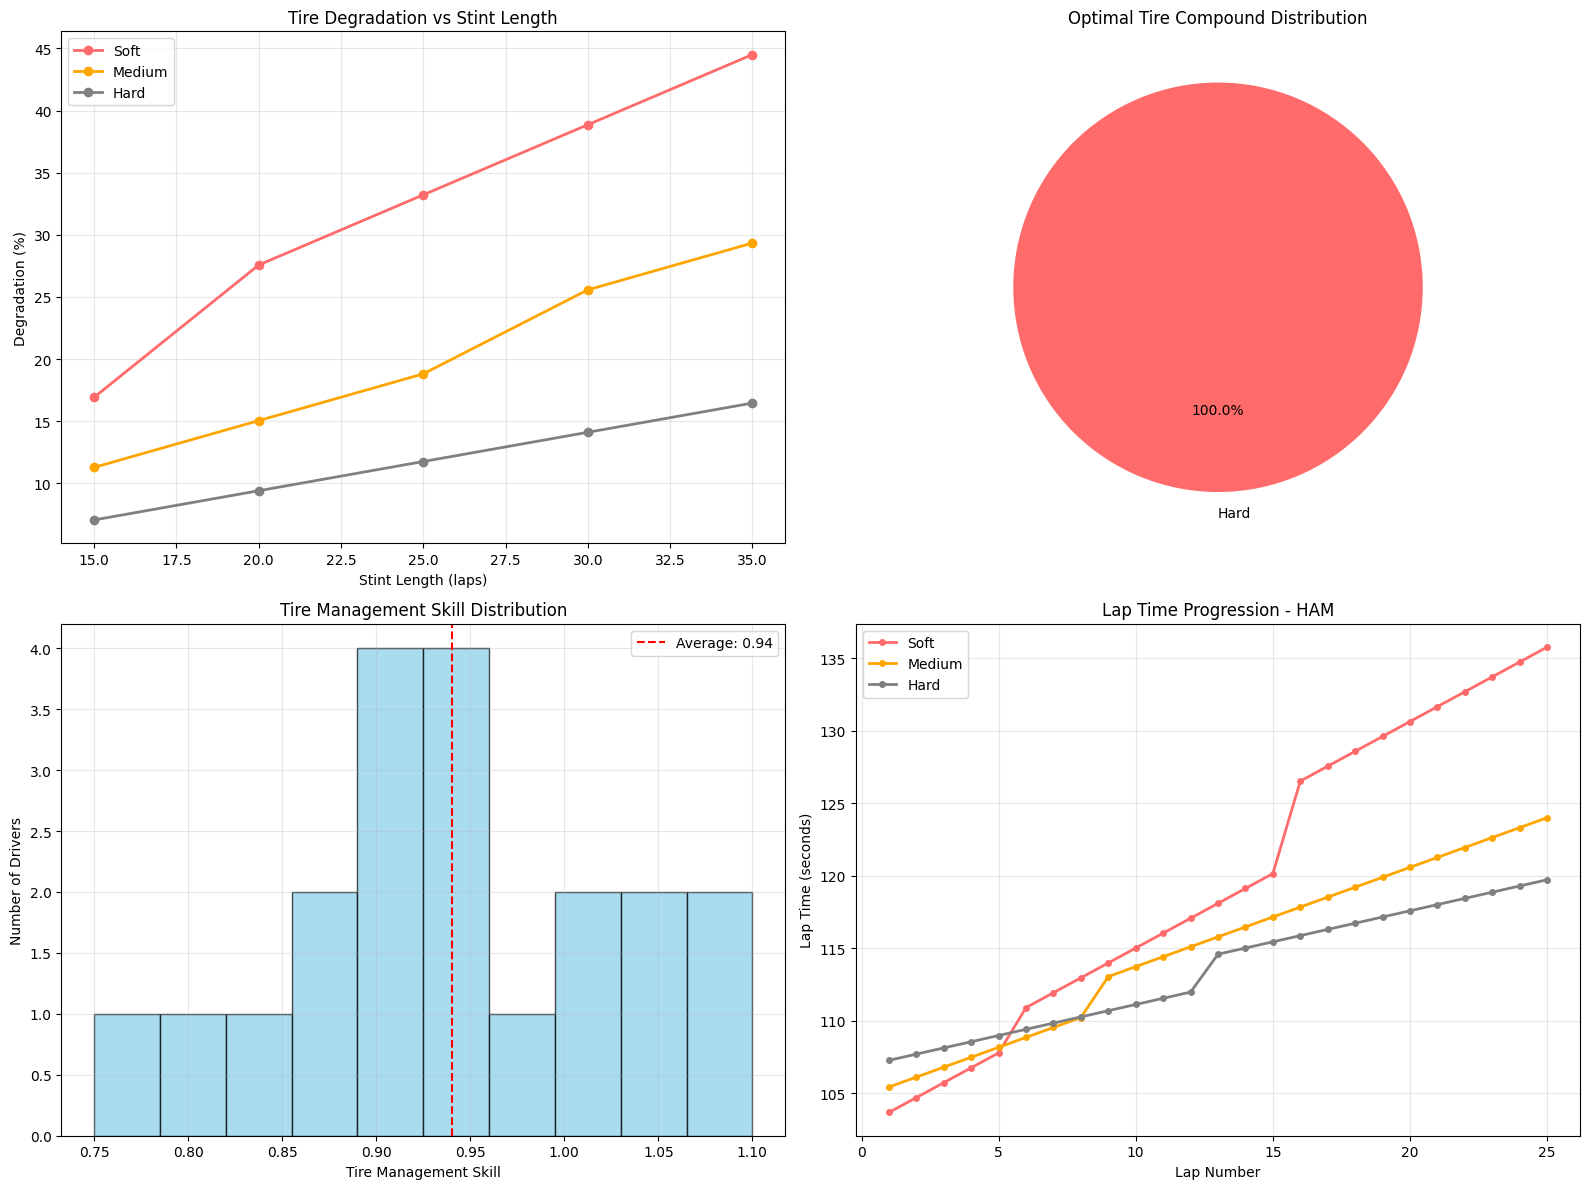


📈 TIRE PERFORMANCE COMPARISON (25-lap stint):
----------------------------------------------------------------------
Compound   Avg Lap Time    Degradation     Best For            
----------------------------------------------------------------------
Soft       119.822         33.2%           HAM                 
Medium     115.110         18.8%           HAM                 
Hard       113.550         11.8%           HAM                 


In [23]:
# Tire Performance Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Degradation over stint length
compounds = ['Soft', 'Medium', 'Hard']
colors = ['#FF6B6B', '#FFA500', '#808080']

for i, compound in enumerate(compounds):
    stint_lengths = [15, 20, 25, 30, 35]
    avg_degradations = []
    
    for stint_length in stint_lengths:
        total_deg = 0
        count = 0
        
        for driver, compounds_data in tire_simulation_results.items():
            if compound in compounds_data and stint_length in compounds_data[compound]:
                total_deg += compounds_data[compound][stint_length]['total_degradation']
                count += 1
        
        avg_degradations.append(total_deg / count if count > 0 else 0)
    
    ax1.plot(stint_lengths, [d * 100 for d in avg_degradations], 
             marker='o', linewidth=2, color=colors[i], label=compound)

ax1.set_xlabel('Stint Length (laps)')
ax1.set_ylabel('Degradation (%)')
ax1.set_title('Tire Degradation vs Stint Length')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Optimal compound distribution
compound_counts = [len(drivers) for drivers in compound_groups.values()]
compound_labels = list(compound_groups.keys())

ax2.pie(compound_counts, labels=compound_labels, autopct='%1.1f%%', 
        colors=colors[:len(compound_labels)], startangle=90)
ax2.set_title('Optimal Tire Compound Distribution')

# 3. Tire management skill distribution
management_values = list(tire_management_skills.values())
ax3.hist(management_values, bins=10, color='skyblue', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Tire Management Skill')
ax3.set_ylabel('Number of Drivers')
ax3.set_title('Tire Management Skill Distribution')
ax3.axvline(np.mean(management_values), color='red', linestyle='--', 
            label=f'Average: {np.mean(management_values):.2f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Lap time progression for different compounds (example driver: VER)
example_driver = 'HAM'
lap_numbers = range(1, 26)  # 25 laps

for i, compound in enumerate(compounds):
    if compound in tire_simulation_results[example_driver]:
        performance_data = tire_simulation_results[example_driver][compound][25]['performance_data']
        lap_times = [p['lap_time'] for p in performance_data]
        
        ax4.plot(lap_numbers, lap_times, marker='o', linewidth=2, 
                color=colors[i], label=f'{compound}', markersize=4)

ax4.set_xlabel('Lap Number')
ax4.set_ylabel('Lap Time (seconds)')
ax4.set_title(f'Lap Time Progression - {example_driver}')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison table
print("\n📈 TIRE PERFORMANCE COMPARISON (25-lap stint):")
print("-" * 70)
print(f"{'Compound':<10} {'Avg Lap Time':<15} {'Degradation':<15} {'Best For':<20}")
print("-" * 70)

for compound in compounds:
    # Find best driver for this compound
    best_driver = None
    best_time = float('inf')
    
    for driver, compounds_data in tire_simulation_results.items():
        if compound in compounds_data and 25 in compounds_data[compound]:
            avg_time = compounds_data[compound][25]['avg_lap_time']
            if avg_time < best_time:
                best_time = avg_time
                best_driver = driver
    
    avg_deg = avg_degradation.get(compound, 0)
    print(f"{compound:<10} {best_time:<15.3f} {avg_deg:<15.1%} {best_driver:<20}")

In [24]:
# Overtaking Probability Matrix Data
# Historical overtaking data at Spa-Francorchamps
overtaking_zones = {
    'Kemmel_Straight': {'difficulty': 0.3, 'drs_effect': 0.4, 'slipstream_benefit': 0.35},
    'Bus_Stop': {'difficulty': 0.6, 'drs_effect': 0.0, 'slipstream_benefit': 0.1},
    'La_Source': {'difficulty': 0.7, 'drs_effect': 0.0, 'slipstream_benefit': 0.15},
    'Rivage': {'difficulty': 0.8, 'drs_effect': 0.0, 'slipstream_benefit': 0.2}
}

# Driver overtaking skills (attack/defense ratings)
overtaking_skills = {
    "VER": {'attack': 0.95, 'defense': 0.90, 'racecraft': 0.95},
    "HAM": {'attack': 0.92, 'defense': 0.88, 'racecraft': 0.93},
    "ALO": {'attack': 0.88, 'defense': 0.95, 'racecraft': 0.92},
    "LEC": {'attack': 0.90, 'defense': 0.85, 'racecraft': 0.88},
    "NOR": {'attack': 0.85, 'defense': 0.80, 'racecraft': 0.85},
    "PIA": {'attack': 0.82, 'defense': 0.83, 'racecraft': 0.84},
    "RUS": {'attack': 0.80, 'defense': 0.85, 'racecraft': 0.82},
    "SAI": {'attack': 0.78, 'defense': 0.82, 'racecraft': 0.80},
    "STR": {'attack': 0.70, 'defense': 0.88, 'racecraft': 0.78},
    "OCO": {'attack': 0.75, 'defense': 0.90, 'racecraft': 0.80},
    "ALB": {'attack': 0.72, 'defense': 0.78, 'racecraft': 0.75},
    "GAS": {'attack': 0.74, 'defense': 0.76, 'racecraft': 0.74},
    "HUL": {'attack': 0.76, 'defense': 0.82, 'racecraft': 0.77},
    "TSU": {'attack': 0.68, 'defense': 0.70, 'racecraft': 0.69},
    "BEA": {'attack': 0.60, 'defense': 0.65, 'racecraft': 0.62},
    "LAW": {'attack': 0.72, 'defense': 0.75, 'racecraft': 0.73},
    "COL": {'attack': 0.70, 'defense': 0.73, 'racecraft': 0.71},
    "BOR": {'attack': 0.58, 'defense': 0.62, 'racecraft': 0.60},
    "HAD": {'attack': 0.55, 'defense': 0.60, 'racecraft': 0.58},
    "ANT": {'attack': 0.65, 'defense': 0.68, 'racecraft': 0.66}
}

# Car performance differential impact
def get_car_performance_factor(attacking_team, defending_team):
    """Calculate car performance advantage/disadvantage"""
    team_performance = {
        'McLaren': 1.00, 'Ferrari': 0.95, 'Mercedes': 0.92, 'Red Bull': 0.88,
        'Williams': 0.75, 'Kick Sauber': 0.70, 'Racing Bulls': 0.68, 
        'Aston Martin': 0.65, 'Haas': 0.62, 'Alpine': 0.58
    }
    
    attacking_perf = team_performance.get(attacking_team, 0.5)
    defending_perf = team_performance.get(defending_team, 0.5)
    
    return attacking_perf - defending_perf

# Calculate overtaking probability between two drivers
def calculate_overtaking_probability(attacker, defender, attacker_team, defender_team, 
                                   track_position_factor=1.0, tire_advantage=0.0):
    """
    Calculate probability of successful overtake
    """
    # Get driver skills
    attacker_skills = overtaking_skills[attacker]
    defender_skills = overtaking_skills[defender]
    
    # Base probability from driver skills
    base_probability = (attacker_skills['attack'] - defender_skills['defense']) * 0.5 + 0.5
    
    # Car performance impact
    car_factor = get_car_performance_factor(attacker_team, defender_team)
    
    # Track position impact (easier to overtake from close behind)
    position_factor = min(track_position_factor, 1.0)
    
    # Tire advantage impact
    tire_factor = tire_advantage * 0.3
    
    # Combine all factors
    final_probability = base_probability + car_factor * 0.3 + position_factor * 0.2 + tire_factor
    
    # Spa-specific adjustment (easier overtaking track)
    spa_bonus = 0.15
    final_probability += spa_bonus
    
    # Clamp between 0 and 1
    return max(0.0, min(1.0, final_probability))

# Generate overtaking probability matrix
overtaking_matrix = {}
driver_list = list(overtaking_skills.keys())

for attacker in driver_list:
    overtaking_matrix[attacker] = {}
    attacker_team = next(team for driver, team in driver_lineup_2025.items() if driver == attacker)
    
    for defender in driver_list:
        if attacker != defender:
            defender_team = next(team for driver, team in driver_lineup_2025.items() if driver == defender)
            
            # Calculate different scenarios
            scenarios = {
                'equal_tires': calculate_overtaking_probability(attacker, defender, attacker_team, defender_team),
                'tire_advantage': calculate_overtaking_probability(attacker, defender, attacker_team, defender_team, tire_advantage=1.0),
                'fresh_vs_old': calculate_overtaking_probability(attacker, defender, attacker_team, defender_team, tire_advantage=2.0),
                'drs_zone': calculate_overtaking_probability(attacker, defender, attacker_team, defender_team) + 0.25
            }
            
            # Clamp DRS zone probability
            scenarios['drs_zone'] = min(scenarios['drs_zone'], 1.0)
            
            overtaking_matrix[attacker][defender] = scenarios
        else:
            overtaking_matrix[attacker][defender] = {'equal_tires': 0.0, 'tire_advantage': 0.0, 'fresh_vs_old': 0.0, 'drs_zone': 0.0}

# Calculate expected overtaking events during race
def simulate_overtaking_events():
    """Simulate expected overtaking events during the race"""
    expected_events = {}
    
    for i, row in final_results.iterrows():
        attacker = row['Driver']
        attacker_team = row['Team']
        expected_events[attacker] = {'attempted': 0, 'successful': 0, 'targets': []}
        
        # Look at drivers ahead (potential overtaking targets)
        for j in range(max(0, i-3), i):  # Only consider close drivers ahead
            if j >= 0:
                defender = final_results.iloc[j]['Driver']
                defender_team = final_results.iloc[j]['Team']
                
                # Calculate probability
                prob = overtaking_matrix[attacker][defender]['equal_tires']
                
                # Expected attempts (based on pace difference and position)
                pace_diff = (clean_air_race_pace[defender] - clean_air_race_pace[attacker]) / clean_air_race_pace[attacker]
                if pace_diff > 0.01:  # Attacker is faster
                    attempts = min(3, int(pace_diff * 100))  # More attempts if much faster
                    expected_events[attacker]['attempted'] += attempts
                    expected_events[attacker]['successful'] += attempts * prob
                    expected_events[attacker]['targets'].append({
                        'target': defender,
                        'probability': prob,
                        'attempts': attempts
                    })
    
    return expected_events

expected_overtaking = simulate_overtaking_events()

# Calculate defensive statistics
defensive_stats = {}
for defender in driver_list:
    defensive_stats[defender] = {
        'attacks_faced': 0,
        'successful_defenses': 0,
        'defense_rate': 0.0
    }
    
    for attacker in driver_list:
        if attacker != defender:
            prob = overtaking_matrix[attacker][defender]['equal_tires']
            if prob > 0.3:  # Realistic overtaking attempt
                defensive_stats[defender]['attacks_faced'] += 1
                defensive_stats[defender]['successful_defenses'] += (1 - prob)
    
    if defensive_stats[defender]['attacks_faced'] > 0:
        defensive_stats[defender]['defense_rate'] = (
            defensive_stats[defender]['successful_defenses'] / 
            defensive_stats[defender]['attacks_faced']
        )

In [25]:
print("\n🏁 OVERTAKING PROBABILITY MATRIX")
print("=" * 70)

print("📊 TOP OVERTAKING THREATS:")
print("-" * 40)

# Find drivers with highest overtaking potential
overtaking_potential = {}
for attacker in driver_list:
    total_prob = 0
    count = 0
    
    for defender in driver_list:
        if attacker != defender:
            prob = overtaking_matrix[attacker][defender]['equal_tires']
            total_prob += prob
            count += 1
    
    overtaking_potential[attacker] = total_prob / count if count > 0 else 0

# Sort by overtaking potential
sorted_overtakers = sorted(overtaking_potential.items(), key=lambda x: x[1], reverse=True)

for i, (driver, potential) in enumerate(sorted_overtakers[:10]):
    rating = "Excellent" if potential > 0.6 else "Good" if potential > 0.5 else "Average"
    print(f"{i+1:2d}. {driver}: {potential:.1%} avg success rate ({rating})")

print("\n🛡️  BEST DEFENDERS:")
print("-" * 25)

# Sort by defense rate
sorted_defenders = sorted(defensive_stats.items(), key=lambda x: x[1]['defense_rate'], reverse=True)

for i, (driver, stats) in enumerate(sorted_defenders[:10]):
    if stats['attacks_faced'] > 0:
        print(f"{i+1:2d}. {driver}: {stats['defense_rate']:.1%} defense rate")

print("\n🎯 EXPECTED OVERTAKING EVENTS:")
print("-" * 40)

# Show expected overtaking events
total_attempts = 0
total_successful = 0

for driver, events in expected_overtaking.items():
    if events['attempted'] > 0:
        success_rate = events['successful'] / events['attempted']
        total_attempts += events['attempted']
        total_successful += events['successful']
        
        print(f"{driver}: {events['attempted']:.1f} attempts, {events['successful']:.1f} successful ({success_rate:.1%})")

print(f"\nTotal Race Overtakes: {total_successful:.1f} expected")
print(f"Overall Success Rate: {total_successful/total_attempts:.1%}")


🏁 OVERTAKING PROBABILITY MATRIX
📊 TOP OVERTAKING THREATS:
----------------------------------------
 1. HAM: 95.5% avg success rate (Excellent)
 2. VER: 95.1% avg success rate (Excellent)
 3. LEC: 94.8% avg success rate (Excellent)
 4. NOR: 94.0% avg success rate (Excellent)
 5. PIA: 93.0% avg success rate (Excellent)
 6. RUS: 90.2% avg success rate (Excellent)
 7. ALO: 86.2% avg success rate (Excellent)
 8. SAI: 84.0% avg success rate (Excellent)
 9. TSU: 82.8% avg success rate (Excellent)
10. ANT: 82.5% avg success rate (Excellent)

🛡️  BEST DEFENDERS:
-------------------------
 1. HAM: 27.4% defense rate
 2. VER: 26.3% defense rate
 3. PIA: 26.2% defense rate
 4. LEC: 25.9% defense rate
 5. NOR: 24.8% defense rate
 6. RUS: 24.6% defense rate
 7. ALO: 21.3% defense rate
 8. SAI: 17.7% defense rate
 9. OCO: 17.5% defense rate
10. STR: 17.4% defense rate

🎯 EXPECTED OVERTAKING EVENTS:
----------------------------------------
ALB: 1.0 attempts, 0.9 successful (93.1%)
LAW: 1.0 attempts, 

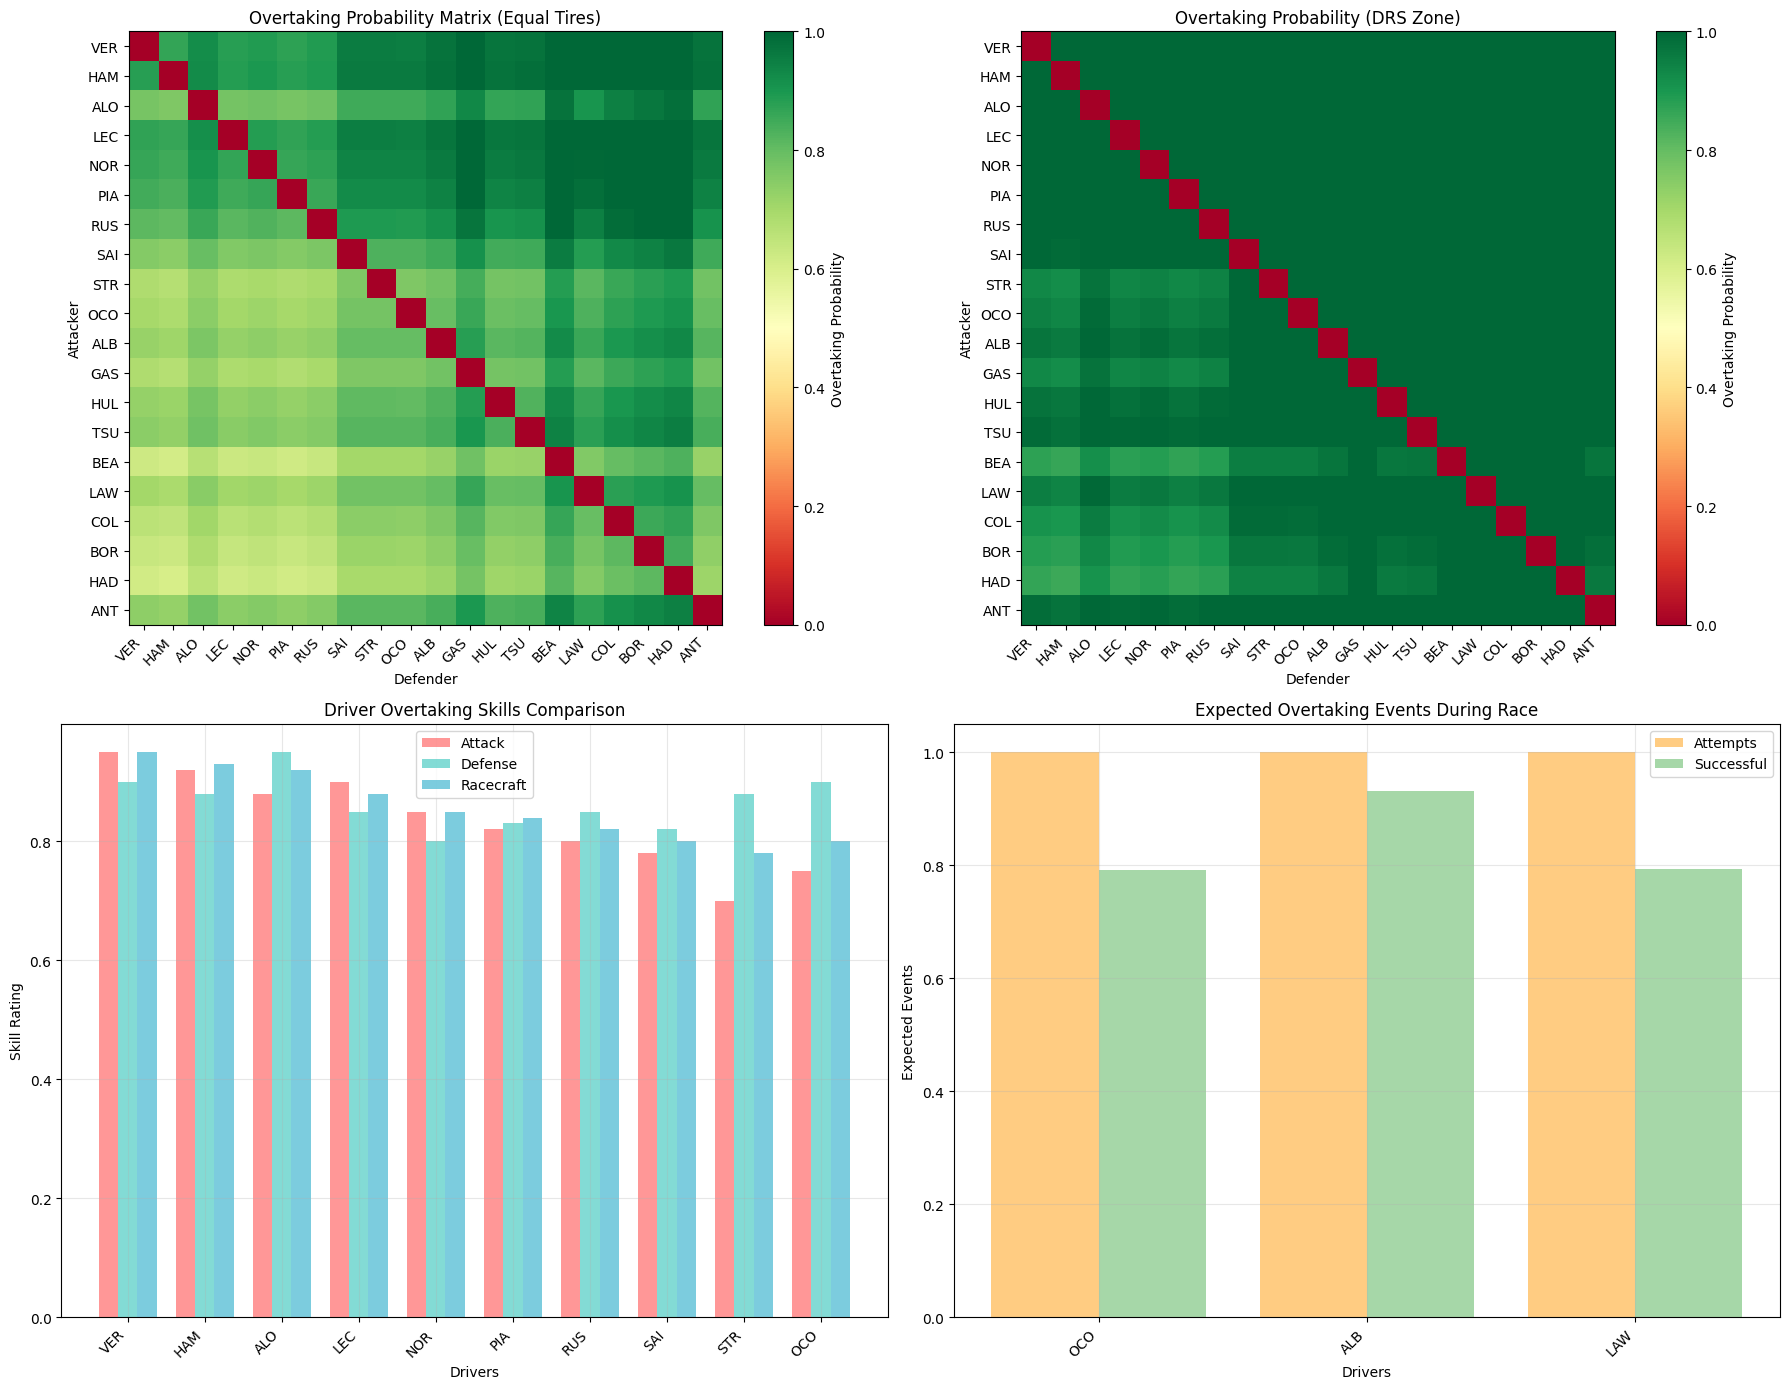


🔍 DETAILED OVERTAKING SCENARIOS:
--------------------------------------------------

Equal Tires:
------------------------------
VER → GAS: 100.0%
VER → BEA: 100.0%
VER → LAW: 100.0%
VER → COL: 100.0%
VER → BOR: 100.0%

Tire Advantage:
------------------------------
VER → HAM: 100.0%
VER → ALO: 100.0%
VER → LEC: 100.0%
VER → NOR: 100.0%
VER → PIA: 100.0%

Fresh vs Old:
------------------------------
VER → HAM: 100.0%
VER → ALO: 100.0%
VER → LEC: 100.0%
VER → NOR: 100.0%
VER → PIA: 100.0%

DRS Zone:
------------------------------
VER → HAM: 100.0%
VER → ALO: 100.0%
VER → LEC: 100.0%
VER → NOR: 100.0%
VER → PIA: 100.0%


In [26]:
# Overtaking Matrix Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# 1. Overtaking Probability Heatmap
matrix_data = np.zeros((len(driver_list), len(driver_list)))
for i, attacker in enumerate(driver_list):
    for j, defender in enumerate(driver_list):
        matrix_data[i][j] = overtaking_matrix[attacker][defender]['equal_tires']

im1 = ax1.imshow(matrix_data, cmap='RdYlGn', aspect='equal', vmin=0, vmax=1)
ax1.set_xticks(range(len(driver_list)))
ax1.set_yticks(range(len(driver_list)))
ax1.set_xticklabels(driver_list, rotation=45, ha='right')
ax1.set_yticklabels(driver_list)
ax1.set_xlabel('Defender')
ax1.set_ylabel('Attacker')
ax1.set_title('Overtaking Probability Matrix (Equal Tires)')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Overtaking Probability')

# 2. DRS Zone Advantage
drs_matrix = np.zeros((len(driver_list), len(driver_list)))
for i, attacker in enumerate(driver_list):
    for j, defender in enumerate(driver_list):
        drs_matrix[i][j] = overtaking_matrix[attacker][defender]['drs_zone']

im2 = ax2.imshow(drs_matrix, cmap='RdYlGn', aspect='equal', vmin=0, vmax=1)
ax2.set_xticks(range(len(driver_list)))
ax2.set_yticks(range(len(driver_list)))
ax2.set_xticklabels(driver_list, rotation=45, ha='right')
ax2.set_yticklabels(driver_list)
ax2.set_xlabel('Defender')
ax2.set_ylabel('Attacker')
ax2.set_title('Overtaking Probability (DRS Zone)')

cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Overtaking Probability')

# 3. Driver Skills Comparison
drivers_subset = driver_list[:10]  # Top 10 for readability
attack_skills = [overtaking_skills[d]['attack'] for d in drivers_subset]
defense_skills = [overtaking_skills[d]['defense'] for d in drivers_subset]
racecraft_skills = [overtaking_skills[d]['racecraft'] for d in drivers_subset]

x = np.arange(len(drivers_subset))
width = 0.25

bars1 = ax3.bar(x - width, attack_skills, width, label='Attack', color='#FF6B6B', alpha=0.7)
bars2 = ax3.bar(x, defense_skills, width, label='Defense', color='#4ECDC4', alpha=0.7)
bars3 = ax3.bar(x + width, racecraft_skills, width, label='Racecraft', color='#45B7D1', alpha=0.7)

ax3.set_xlabel('Drivers')
ax3.set_ylabel('Skill Rating')
ax3.set_title('Driver Overtaking Skills Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(drivers_subset, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Expected Overtaking Events
drivers_with_events = [d for d in driver_list if expected_overtaking[d]['attempted'] > 0]
attempts = [expected_overtaking[d]['attempted'] for d in drivers_with_events]
successful = [expected_overtaking[d]['successful'] for d in drivers_with_events]

x = np.arange(len(drivers_with_events))
bars1 = ax4.bar(x - 0.2, attempts, 0.4, label='Attempts', color='#FFB74D', alpha=0.7)
bars2 = ax4.bar(x + 0.2, successful, 0.4, label='Successful', color='#81C784', alpha=0.7)

ax4.set_xlabel('Drivers')
ax4.set_ylabel('Expected Events')
ax4.set_title('Expected Overtaking Events During Race')
ax4.set_xticks(x)
ax4.set_xticklabels(drivers_with_events, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed overtaking scenarios
print("\n🔍 DETAILED OVERTAKING SCENARIOS:")
print("-" * 50)

scenarios = ['equal_tires', 'tire_advantage', 'fresh_vs_old', 'drs_zone']
scenario_names = ['Equal Tires', 'Tire Advantage', 'Fresh vs Old', 'DRS Zone']

for i, scenario in enumerate(scenarios):
    print(f"\n{scenario_names[i]}:")
    print("-" * 30)
    
    # Find most likely overtakes in this scenario
    overtake_chances = []
    for attacker in driver_list:
        for defender in driver_list:
            if attacker != defender:
                prob = overtaking_matrix[attacker][defender][scenario]
                if prob > 0.6:  # High probability overtakes
                    overtake_chances.append((attacker, defender, prob))
    
    # Sort by probability
    overtake_chances.sort(key=lambda x: x[2], reverse=True)
    
    for attacker, defender, prob in overtake_chances[:5]:  # Top 5
        print(f"{attacker} → {defender}: {prob:.1%}")